In [ ]:
!pip install tensorflow

import pandas as pd
import numpy as np
import tensorflow as tf

# Load the ner dataset from the CSV file
df = pd.read_csv('ner_dataset.csv', encoding='latin1', error_bad_lines=False)
df = df.fillna(method="ffill")

# Preprocess the data to split the text into sentences and annotate the named entities
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                           s['POS'].values.tolist(),
                                                           s['Tag'].values.tolist())]
        self.grouped = self.data.groupby('Sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]

getter = SentenceGetter(df)
sentences = getter.sentences




In [7]:
# Prepare the data for training by converting the text and labeled entities into numerical representations
words = list(set(df['Word'].values))
words.append("ENDPAD")
n_words = len(words)

tags = list(set(df['Tag'].values))
n_tags = len(tags)

word2idx = {}
for sentence in sentences:
    for word in sentence:
        if word[0] not in word2idx:
            word2idx[word[0]] = len(word2idx)

tag2idx = {}
for sentence in sentences:
    for word in sentence:
        if word[2] not in tag2idx:
            tag2idx[word[2]] = len(tag2idx)


# Define and train your neural network
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

max_len = 75
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words-1)

# Convert tags to indices
y = [[tag2idx[w[2]] for w in s] for s in sentences]

# Pad sequences
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

# Convert indices to one-hot encoding
y = [to_categorical(i, num_classes=n_tags) for i in y]

# Split data into training and testing sets
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.optimizers import Adam

# Define the model architecture
model = Sequential()
model.add(Embedding(input_dim=n_words, output_dim=50, input_length=max_len))
model.add(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))
model.add(Dense(n_tags, activation="softmax"))

# Compile the model
model.compile(optimizer=Adam(lr=0.01), loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5, validation_split=0.1, verbose=1)

# Evaluate the model on the test set
score = model.evaluate(X_te, np.array(y_te), verbose=1)
print(f"Test loss: {score[0]} / Test accuracy: {score[1]}")


Epoch 1/5
1080/1080 [==============================] - 198s 179ms/step - loss: 0.1778 - accuracy: 0.9647 - val_loss: 0.0804 - val_accuracy: 0.9778
Epoch 2/5
1080/1080 [==============================] - 191s 177ms/step - loss: 0.0523 - accuracy: 0.9858 - val_loss: 0.0450 - val_accuracy: 0.9872
Epoch 3/5
1080/1080 [==============================] - 193s 179ms/step - loss: 0.0342 - accuracy: 0.9899 - val_loss: 0.0400 - val_accuracy: 0.9879
Epoch 4/5
1080/1080 [==============================] - 198s 183ms/step - loss: 0.0282 - accuracy: 0.9911 - val_loss: 0.0389 - val_accuracy: 0.9882
Epoch 5/5
300/300 [==============================] - 9s 31ms/step - loss: 0.0393 - accuracy: 0.9884
Test loss: 0.03930531442165375 / Test accuracy: 0.9884334206581116


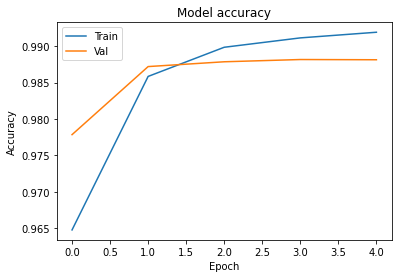

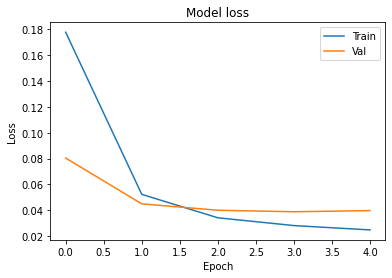

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()
